In [1]:
from torchvision import datasets, transforms
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

### Question2 a

In [3]:
#Encoder and decoder (latent space 2) 
class Autoencoder_latent_2(nn.Module):
    def __init__(self):
        super(Autoencoder_latent_2,self).__init__()
        self.encoder = nn.Sequential(
            # initial size 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 2)
            # 2
            )
        self.decoder = nn.Sequential(
            # 2
            nn.Linear(2, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5)
            # 28 x 28
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [4]:
#Encoder and decoder (latent space 16)
class Autoencoder_latent_16(nn.Module):
    def __init__(self):
        super(Autoencoder_latent_16,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 16)
            # 16
            )
        self.decoder = nn.Sequential(
            # 16
            nn.Linear(16, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5)
            # 28 x 28
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [5]:
#Encoder and decoder (latent space 256)
class Autoencoder_latent_256(nn.Module):
    def __init__(self):
        super(Autoencoder_latent_256,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 256)
            # 256
            #nn.Softmax(),
            )
        self.decoder = nn.Sequential(
            # 256
            nn.Linear(256, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5)
            # 28 x 28
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [6]:
og_set = datasets.MNIST(root='./data',  train=False, download=True, transform=transforms.ToTensor())
og_dataloader = torch.utils.data.DataLoader(og_set, batch_size=128, shuffle=False, num_workers=4)

In [7]:
model_latent_2 = Autoencoder_latent_2().to(device)
model_latent_16 = Autoencoder_latent_16().to(device)
model_latent_256 = Autoencoder_latent_256().to(device)

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [9]:
#L1_loss
distance = nn.L1Loss()
#Adam optimizer
optimizer_latent_2 = torch.optim.Adam(model_latent_2.parameters(), lr=0.001)
optimizer_latent_16 = torch.optim.Adam(model_latent_16.parameters(), lr=0.001)
optimizer_latent_256 = torch.optim.Adam(model_latent_256.parameters(), lr=0.001)

outputs = []

for epoch in range(6):
    for og_data in og_dataloader:
        og_img, og_ = og_data[0].to(device), og_data[1].to(device) 
        output_latent_2 = model_latent_2(og_img)
        output_latent_16 = model_latent_16(og_img)
        output_latent_256 = model_latent_256(og_img)
        loss_latent_2 = distance(output_latent_2, og_img) 
        loss_latent_16 = distance(output_latent_16, og_img)
        loss_latent_256 = distance(output_latent_256, og_img)
        optimizer_latent_2.zero_grad()
        optimizer_latent_16.zero_grad()
        optimizer_latent_256.zero_grad()
        loss_latent_2.backward()
        loss_latent_16.backward()
        loss_latent_256.backward()
        optimizer_latent_2.step()
        optimizer_latent_16.step()
        optimizer_latent_256.step()
    outputs.append((epoch, og_img, output_latent_2,output_latent_16,output_latent_256),)
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1,6, loss_latent_2.item(),loss_latent_16.item(),loss_latent_256.item()))

epoch [1/6], loss: 0.1271
epoch [2/6], loss: 0.1143
epoch [3/6], loss: 0.1099
epoch [4/6], loss: 0.1068
epoch [5/6], loss: 0.1053
epoch [6/6], loss: 0.1033


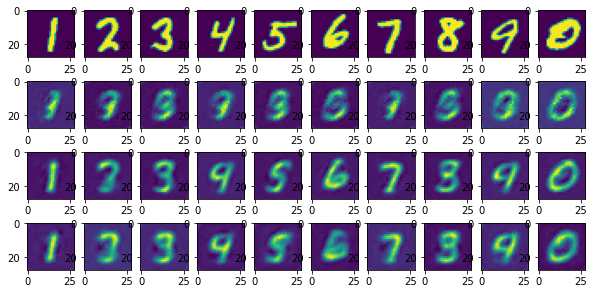

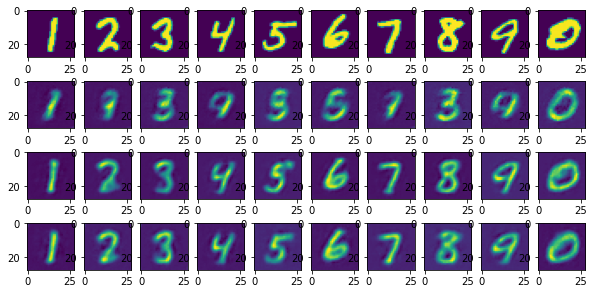

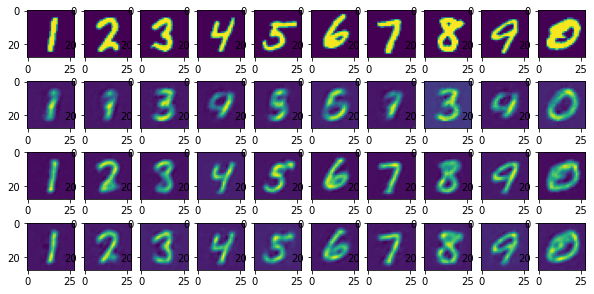

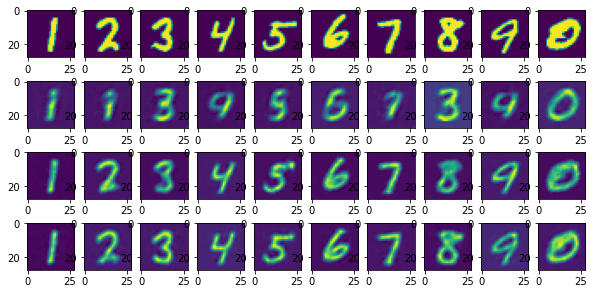

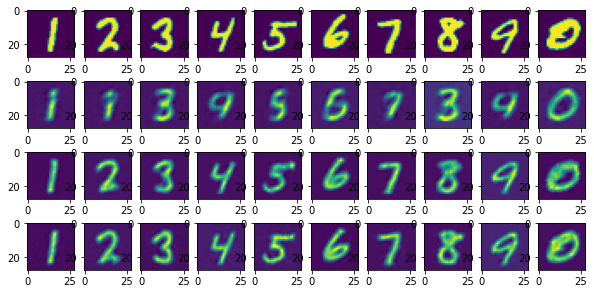

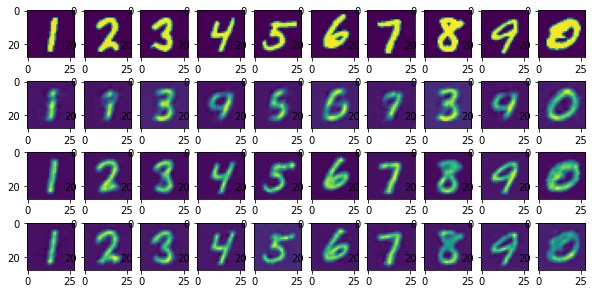

In [10]:
for k in range(6):
    plt.figure(figsize=(10, 5))
    imgs = Variable(outputs[k][1]).cpu().detach().numpy()
    recon_latent_2 = Variable(outputs[k][2]).cpu().detach().numpy()
    recon_latent_16 = Variable(outputs[k][3]).cpu().detach().numpy()
    recon_latent_256 = Variable(outputs[k][4]).cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 10: break
        # i 代表图新编号 第几个
        plt.subplot(4, 10, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_2):
        if i >= 10: break
        plt.subplot(4, 10, 10+i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_16):
        if i >= 10: break
        plt.subplot(4, 10, 20+i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_256):
        if i >= 10: break
        plt.subplot(4, 10, 30+i+1)
        plt.imshow(item[0])

### 2D Plot of Latent Space 2 using t-SNE

In [26]:
# latent space of 2
i = 0 
for data in og_dataloader:
    img, _ = data[0].to(device), data[1]
    if i == 0:
        latent_2 = Variable(model_latent_2.encoder(img)).cpu().detach().numpy()
        labels = _.detach().numpy()
    else:
        labels = np.append(labels,_.detach().numpy())
        latent_2 = np.append(latent_2, Variable(model_latent_2.encoder(img)).cpu().detach().numpy(),axis= 0)
    i+=1

In [27]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, random_state=0)
dataset_tsne = tsne.fit_transform(latent_2)

fig = px.scatter(
    dataset_tsne, x=0, y=1, 
    title="t-SNE Plot",
    color=labels.astype(str),
    labels={'0': 'tsne 1', '1': 'tsne 2'}
)
fig.show()

### K-Means

### Latent space 16

In [28]:
# latent space of 16
i = 0 
for data in og_dataloader:
    img, _ = data[0].to(device), data[1]
    if i == 0:
        latent_16 = Variable(model_latent_16.encoder(img)).cpu().detach().numpy()
        labels = _.detach().numpy()
    else:
        labels = np.append(labels,_.detach().numpy())
        latent_16 = np.append(latent_16, Variable(model_latent_16.encoder(img)).cpu().detach().numpy(),axis= 0)
    i+=1

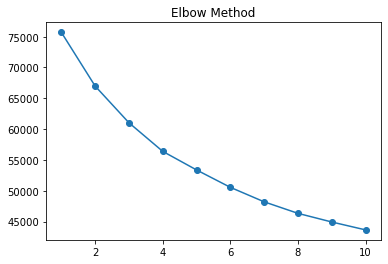

In [29]:
#Elbow Method
distortions=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(latent_16)
    distortions.append(kmeans.inertia_)
    
plt.plot(range(1,11), distortions, marker="o")
plt.title("Elbow Method")
plt.show()


In [31]:
#K-mean cluster for latent space 16
kmeans = KMeans(n_clusters=10, random_state=0).fit(latent_16)
tsne_16 = tsne.fit_transform(latent_16)


fig = px.scatter(
    tsne_16, x=0, y=1, 
    title="t-SNE Plot for kmeans with latent space 16",
    color=kmeans.labels_.astype(str),
    labels={'0': 'tsne 1', '1': 'tsne 2'}
)
fig.show()

### Kmeans for latant space 256

In [32]:
# latent space of 256
i = 0 
for data in og_dataloader:
    img= data[0].to(device)
    if i == 0:
        latent_256 = Variable(model_latent_256.encoder(img)).cpu().detach().numpy()
    else:
        labels = np.append(labels,_.detach().numpy())
        latent_256 = np.append(latent_256, Variable(model_latent_256.encoder(img)).cpu().detach().numpy(),axis= 0)
    i+=1

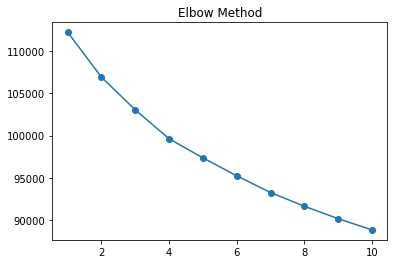

In [33]:
#Elbow Method
distortions=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(latent_256)
    distortions.append(kmeans.inertia_)
    
plt.plot(range(1,11), distortions, marker="o")
plt.title("Elbow Method")
plt.show()


In [35]:
#K-mean cluster for latent space 256
kmeans = KMeans(n_clusters=10, random_state=0).fit(latent_256)
tsne_256 = tsne.fit_transform(latent_256)

fig = px.scatter(
    tsne_256, x=0, y=1, 
    title="t-SNE Plot",
    color=kmeans.labels_.astype(str),
    labels={'0': 'tsne 1', '1': 'tsne 2'}
)
fig.show()

### Question2 b

In [23]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=(9, 9), sigma=(1,10.0))
])
testset = datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
og_set = datasets.MNIST(root='./data',  train=False, download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)
og_dataloader = torch.utils.data.DataLoader(og_set, batch_size=256, shuffle=False, num_workers=4)

In [24]:
#distance = nn.L1Loss()
distance = nn.MSELoss()
optimizer_latent_2 = torch.optim.Adam(model_latent_2.parameters(), lr=0.001)
optimizer_latent_16 = torch.optim.Adam(model_latent_16.parameters(), lr=0.001)
optimizer_latent_256 = torch.optim.Adam(model_latent_256.parameters(), lr=0.001)

output_2 = []

for epoch in range(6):
    for data,og_data in zip(dataloader,og_dataloader):
        img, _ = data[0].to(device), data[1].to(device) 
        og_img, og_ = og_data[0].to(device), og_data[1].to(device) 
        output_latent_2 = model_latent_2(img)
        output_latent_16 = model_latent_16(img)4
        output_latent_256 = model_latent_256(img)
        #L1 loss + discriminer loss
        loss_latent_2 = distance(output_latent_2, img) + distance(output_latent_2, og_img)
        loss_latent_16 = distance(output_latent_16, img)+ distance(output_latent_16, og_img)
        loss_latent_256 = distance(output_latent_256, img)+ distance(output_latent_256, og_img)
        optimizer_latent_2.zero_grad()
        optimizer_latent_16.zero_grad()
        optimizer_latent_256.zero_grad()
        loss_latent_2.backward()
        loss_latent_16.backward()
        loss_latent_256.backward()
        optimizer_latent_2.step()
        optimizer_latent_16.step()
        optimizer_latent_256.step()
    output_2.append((epoch, img, output_latent_2,output_latent_16,output_latent_256),)
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1,6, loss_latent_2.item(),loss_latent_16.item(),loss_latent_256.item()))

epoch [1/6], loss: 0.1960
epoch [2/6], loss: 0.1908
epoch [3/6], loss: 0.1908
epoch [4/6], loss: 0.1885
epoch [5/6], loss: 0.1905
epoch [6/6], loss: 0.1884


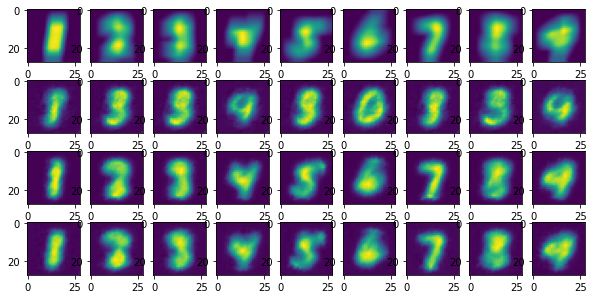

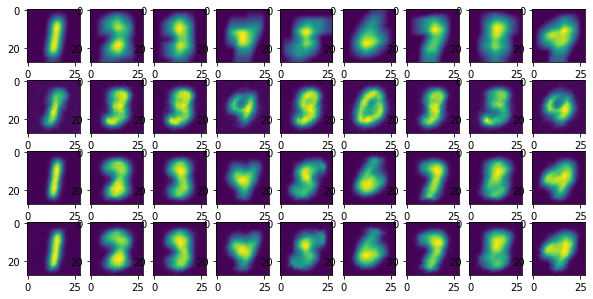

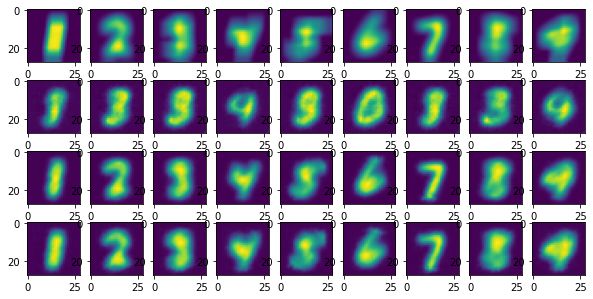

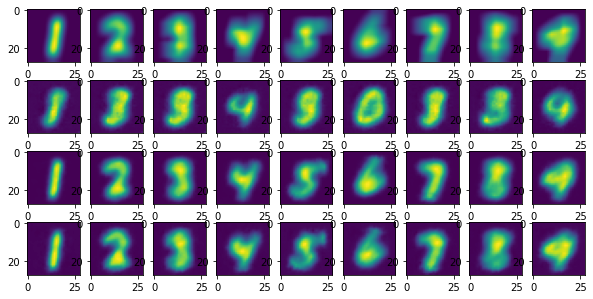

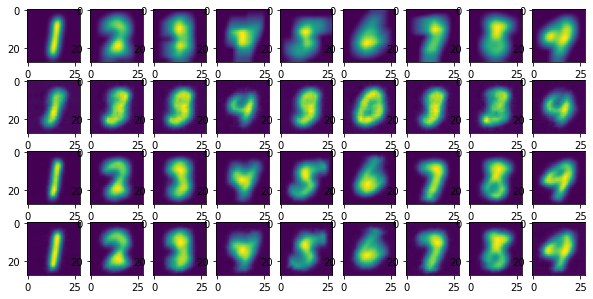

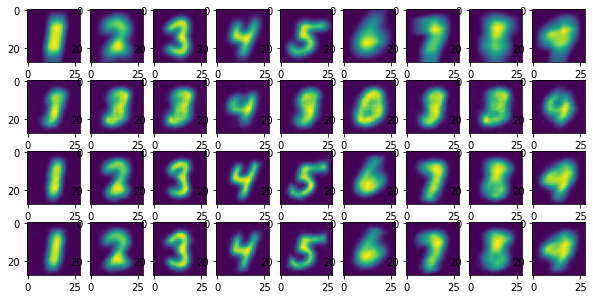

In [25]:
for k in range(6):
    plt.figure(figsize=(10, 5))
    imgs = Variable(output_2[k][1]).cpu().detach().numpy()
    recon_latent_2 = Variable(output_2[k][2]).cpu().detach().numpy()
    recon_latent_16 = Variable(output_2[k][3]).cpu().detach().numpy()
    recon_latent_256 = Variable(output_2[k][4]).cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(4, 9, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_2):
        if i >= 9: break
        plt.subplot(4, 9, 9+i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_16):
        if i >= 9: break
        plt.subplot(4, 9, 18+i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon_latent_256):
        if i >= 9: break
        plt.subplot(4, 9, 27+i+1)
        plt.imshow(item[0])